In [1]:
import time

import gym
import numpy as np
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

import collections
from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [51]:
class OrbitalDynamicsEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, ln_m = 1000.0, dt_s = 1.0, target_r = 2.0, thrust_gs= 1.25, verbose = False, 
                 record_history = True, record_rate = 100):
        super(OrbitalDynamicsEnv, self).__init__()
        self.record_rate = record_rate
    
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([0, 100.0]), 
                                           high=np.array([100.0, 100.0]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot,theta,theta_dot)
        self.observation_space = gym.spaces.Box(low=np.array([0., -10., 0.0, -10.0]), 
                                                high=np.array([10., 10., 2*np.pi, 10.0]), 
                                                dtype=np.float32)
        
        self.record_history = record_history
        
        # Newton's Gravitational Constant in SI units
        G = 6.674*10**(-11) # m^3 kg^-1 s^-2 
        planet_Mass_kg = 5.972*10**(24)
        planet_R_km = 6371.0
        planet_R_m = planet_R_km*10**3
        self.planet_R_ln = planet_R_m/ln_m
        
        # Convert to Natural Problem Units
        # tn_s = (R^2/GM*X m)^1/2 -- where all measures are in SI units
        
        tn_s = (planet_R_m**2/(G*planet_Mass_kg)*ln_m)**0.5
        
        # define the time step in seconds
        self.dts = dt_s
        # define the natural length in meters
        self.ln_m = ln_m
        # convert the time step in seconds to natural time
        self.dt = dt_s/tn_s
        
        self.verbose = verbose
        if verbose:
            print('Units')
            print('-----')
            print('\ttime: 1 s = ', 1.0/tn_s,' tn')
            print('\tlength: 1 m = ',1/ln_m,' ln')
            print('Simulation parameters')
            print('-----')
            print('\tnatural units time step size: ',self.dt)
        
        # setting the target altitude in natural units
        self.target_r = self.planet_R_ln + target_r
        self.max_r = self.planet_R_ln + 2.0*self.target_r
        
        # solving the oribital angular velocity in natural units
        self.orbit_theta_dot = self.planet_R_ln*self.target_r**(-1.5)
        self.max_theta_dot = 5.0*self.orbit_theta_dot
        
        # solving the maxium allowable natural time to run an episode
        self.max_time = 2*np.pi/self.orbit_theta_dot
        # adding in a buffer to allow it to go a little longer
        self.max_time = 5*self.max_time
        # solving the maximum allowable steps given the max time
        self.max_steps = np.int32(np.ceil(self.max_time/self.dt))
        
        if verbose:
            print('\ttarget theta dot: ', self.orbit_theta_dot, ' 1/tn')
            print('\tmax allowable natural time: ', self.max_time, " tn = ", self.max_time*tn_s," s")
            print('\tmax allowed steps: ', self.max_steps)
            
        
        # max accleration from thrust in natural units (ln/tn^2)
        # 1 g = GM/R_planet^2 --in natural units--> 1 g = (ln^3/tn^2)/(ln^2)
        # 1 g. = 1 ln/tn^2
        self.max_thrust = thrust_gs
        self.max_o_thrust = 1.5
        
        if verbose:
            print('Policy Parameters')
            print('-----')
            max_thrust_SI = self.max_thrust*(self.ln_m)/(tn_s**2)
            # as a reference https://www.nasa.gov/pdf/466711main_AP_ST_ShuttleAscent.pdf
            # says the spaceshuttle never exceeded 3gs or ~ 30 m/s^2
            print('\tDiscrete thrust acceleration: ', self.max_thrust,' ln/tn^2 = ', max_thrust_SI,' m/s^2')
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Orientation Coordinate in global coordinates
        self.orientation_rate = 0.0
        self.orientation_angle = 0.0
        
        # Translational Coordinates
        self.r = self.planet_R_ln
        self.r_dot = 0.0
        self.r_double_dot = 0.0
        
        self.theta = 0.0
        self.theta_dot = 0.0 # can change this if u want to add planetary rotation
        self.theta_double_dot = 0.0
        
        self.elapsed_time = 0.0 # elapsed sim time in natural units
        self.elapsed_time_s = 0.0 # elapsed sim time in seconds
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r*np.cos(self.theta), self.r*np.sin(self.theta), 
                                         self.orientation_angle]])
        
        obs = np.array([self.r, self.r_dot, self.theta, self.theta_dot])
        
        return obs
    
    # continous actions = (mean thrust, mean counter clockwise rotation thrust)
    def step(self, action):
        self.steps += 1
        
        # actions segragation
        thrust = np.clip(action[0]*self.max_thrust, 0.0, self.max_thrust)
        orientation_thrust = np.clip(action[1]*self.max_o_thrust, -self.max_o_thrust, self.max_o_thrust) 
        
        #print('thrust: ', thrust)
        #print('orientation_thrust: ', orientation_thrust)

        # Translating the actions into the planet centric coordinate system
        action_vector = thrust*np.array([np.cos(self.orientation_angle), 
                                         np.sin(self.orientation_angle)])
        
        # Apply the orientation action prior to the state propagator
        self.orientation_angle += self.orientation_rate*self.dt + 0.5*orientation_thrust*self.dt**2
        self.orientation_rate += orientation_thrust*self.dt

        # current r hat vector and theta hat vector
        r_vect = np.array([np.cos(self.theta), np.sin(self.theta)])
        theta_vect = np.array([-np.sin(self.theta), np.cos(self.theta)])
        
        # projection of actions along r and theta 
        action_along_r = np.dot(r_vect, action_vector)
        action_along_theta = np.dot(theta_vect, action_vector)
        
        # Execute one time step within the environment using RK4
        self.elapsed_time += self.dt
        self.elapsed_time_s += self.dts

        # integrate
        rd_k1 = self.r_dot
        rdd_k1 = self.r*self.theta_dot**2 - self.planet_R_ln**2/self.r**2 + action_along_r
        thetad_k1 = self.theta_dot
        thetadd_k1 = -2.0*self.r_dot/self.r*self.theta_dot + action_along_theta
        
        rd_k2 = (self.r_dot + rdd_k1*self.dt/2)
        rdd_k2 = (self.r + rd_k1*self.dt/2)*(self.theta_dot + thetadd_k1*self.dt/2)**2 - self.planet_R_ln**2/(self.r + rd_k1*self.dt/2)**2 + action_along_r
        thetad_k2 = (self.theta_dot + thetadd_k1*self.dt/2)
        thetadd_k2 = -2.0*(self.r_dot + rdd_k1*self.dt/2)/(self.r + rd_k1*self.dt/2)*(self.theta_dot + thetadd_k1*self.dt/2) + action_along_theta
        
        rd_k3 = (self.r_dot + rdd_k2*self.dt/2)
        rdd_k3 = (self.r + rd_k2*self.dt/2)*(self.theta_dot + thetadd_k2*self.dt/2)**2 - self.planet_R_ln**2/(self.r + rd_k2*self.dt/2)**2 + action_along_r
        thetad_k3 = (self.theta_dot + thetadd_k2*self.dt/2)
        thetadd_k3 = -2.0*(self.r_dot + rdd_k2*self.dt/2)/(self.r + rd_k2*self.dt/2)*(self.theta_dot + thetadd_k2*self.dt/2) + action_along_theta
        
        rd_k4 = (self.r_dot + rdd_k3*self.dt)
        rdd_k4 = (self.r + rd_k3*self.dt)*(self.theta_dot + thetadd_k3*self.dt)**2 - self.planet_R_ln**2/(self.r + rd_k3*self.dt)**2 + action_along_r
        thetad_k4 = (self.theta_dot + thetadd_k3*self.dt)
        thetadd_k4 = -2.0*(self.r_dot + rdd_k3*self.dt)/(self.r + rd_k3*self.dt)*(self.theta_dot + thetadd_k3*self.dt) + action_along_theta
        
        # Update 
        self.r = self.r + self.dt/6*(rd_k1 + 2*rd_k2 + 2*rd_k3 + rd_k4)
        self.r_dot = self.r_dot + self.dt/6*(rdd_k1 + 2*rdd_k2 + 2*rdd_k3 + rdd_k4)

        self.theta = self.theta + self.dt/6*(thetad_k1 + 2*thetad_k2 + 2*thetad_k3 + thetad_k4)
        self.theta_dot = self.theta_dot + self.dt/6*(thetadd_k1 + 2*thetadd_k2 + 2*thetadd_k3 + thetadd_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot,self.theta,self.theta_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory, 
                                        [[self.r*np.cos(self.theta), 
                                          self.r*np.sin(self.theta), 
                                          self.orientation_angle]], 
                                        axis=0)
        
        # GET TO THE TARGET ALT BY USING THE LEAST THRUST
        
        '''
        reward = 0.0
        if (self.r - self.target_r)**2 < (0.01)**2:
            reward += 2.0
        if (self.theta_dot - self.orbit_theta_dot)**2 < (0.01)**2:
            reward += 2.0
        '''
        
        reward = np.exp(-(self.r - self.target_r)**2/2)
  
        # set if at the terminal state
        done = False
            
        if (self.r < self.planet_R_ln):
            if self.verbose:
                print('surface impact')
            done = True
        
        if self.steps > self.max_steps:
            if self.verbose:
                print('max steps')
            done = True
        
        if (self.r > self.max_r):
            if self.verbose:
                print('max R')
            done = True
            
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1, xlim=None, ylim=None):
        
        fig = plt.figure(figsize=(size,size), dpi=100)
        ax = fig.add_subplot(111)
        ax.set_aspect(1) 
        
        # Planet Surface
        x = np.linspace(-self.planet_R_ln, self.planet_R_ln, 100,endpoint=True)
        plt.plot(x, np.sqrt(self.planet_R_ln**2-x**2), c='k')
        plt.plot(x,-np.sqrt(self.planet_R_ln**2-x**2), c='k')
        
        # Trajectory
        plt.plot(self.trajectory[::sample_traj_rate,0], self.trajectory[::sample_traj_rate,1], c='b')
        
        # orientation vector every Nth
        action_vect_length = 0.05*self.planet_R_ln
        xaxis_orientation = self.trajectory[::sample_traj_rate,2]
        # vector terminal pts
        start_pts = self.trajectory[::sample_traj_rate,[0,1]]
        end_pts = start_pts + action_vect_length*np.dstack((np.cos(xaxis_orientation), np.sin(xaxis_orientation)))[0]
        
        for idx in range(len(start_pts)):
            plt.plot([start_pts[idx,0],end_pts[idx,0]], [start_pts[idx,1],end_pts[idx,1]], c='r')
        
        if xlim != None:
            plt.xlim(xlim[0], xlim[1])
            plt.ylim(ylim[0], ylim[1])
        plt.show();
        
        fig, axs = plt.subplots(3, sharex=False, sharey=False, figsize=(size,size), dpi=100)
        axs[0].plot(np.sqrt(self.trajectory[::sample_traj_rate,0]**2+self.trajectory[::sample_traj_rate,1]**2), c='b')
        axs[0].set_ylabel('altitude (ln)')
        axs[0].set_xlabel('time (steps)')
        
        axs[1].plot(np.arctan2(self.trajectory[::sample_traj_rate,1],self.trajectory[::sample_traj_rate,0])*180/np.pi, c='b')
        axs[1].set_ylabel('latitude (degrees)')
        axs[1].set_xlabel('time (steps)')
        
        axs[2].plot((self.trajectory[::sample_traj_rate,2]*180/np.pi) % 360, c='b')
        axs[2].set_ylabel('orientation to x-axis (degrees)')
        axs[2].set_xlabel('time (steps)')
        plt.tight_layout()

In [60]:
env = OrbitalDynamicsEnv(dt_s = 5.0, ln_m = 6371000.0, target_r = 1.0, thrust_gs= 1.1, record_history=False)
test_env = OrbitalDynamicsEnv(dt_s = 5.0, ln_m = 6371000.0, target_r = 1.0, thrust_gs= 1.1, record_history=False)
render_env = OrbitalDynamicsEnv(dt_s = 5.0, ln_m = 6371000.0, target_r = 1.0, thrust_gs= 1.1, 
                              record_history=True, 
                              verbose=True, record_rate = 5)

Units
-----
	time: 1 s =  0.0012414853327976582  tn
	length: 1 m =  1.5696123057604772e-07  ln
Simulation parameters
-----
	natural units time step size:  0.006207426663988292
	target theta dot:  0.3535533905932738  1/tn
	max allowable natural time:  88.85765876316732  tn =  71573.6677798107  s
	max allowed steps:  14315
Policy Parameters
-----
	Discrete thrust acceleration:  1.1  ln/tn^2 =  10.801485236097557  m/s^2


C:\Users\BVPHD\.conda\envs\py_torch\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [61]:
GAMMA = 0.99
GAE_LAMBDA = 0.95

TRAJECTORY_SIZE = 2049
LEARNING_RATE_ACTOR = 1e-4
LEARNING_RATE_CRITIC = 1e-3

PPO_EPS = 0.01
PPO_EPOCHES = 10
PPO_BATCH_SIZE = 64

TEST_ITERS = 5000

In [62]:
def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs]).to(device)
            mu_v = net(obs_v)[0]
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            action = np.clip(action, -1, 1)
            obs, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    
    return rewards / count, steps / count


def calc_logprob(mu_v, logstd_v, actions_v):
    p1 = - ((mu_v - actions_v)**2)/(2*torch.exp(logstd_v).clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2*np.pi*torch.exp(logstd_v)))
    return p1 + p2


def calc_adv_ref(trajectory, net_crt, states_v, device="cpu"):
    """
    By trajectory calculate advantage and 1-step ref value
    :param trajectory: trajectory list
    :param net_crt: critic network
    :param states_v: states tensor
    :return: tuple with advantage numpy array and reference values
    """
    values_v = net_crt(states_v)
    values = values_v.squeeze().data.cpu().numpy()
    # generalized advantage estimator: smoothed version of the advantage
    last_gae = 0.0
    result_adv = []
    result_ref = []
    for val, next_val, (exp,) in zip(reversed(values[:-1]), reversed(values[1:]),
                                     reversed(trajectory[:-1])):
        if exp.done:
            delta = exp.reward - val
            last_gae = delta
        else:
            delta = exp.reward + GAMMA * next_val - val
            last_gae = delta + GAMMA * GAE_LAMBDA * last_gae
        result_adv.append(last_gae)
        result_ref.append(last_gae + val)

    adv_v = torch.FloatTensor(list(reversed(result_adv))).to(device)
    ref_v = torch.FloatTensor(list(reversed(result_ref))).to(device)
    return adv_v, ref_v

In [64]:
HID_SIZE = 256

class ModelActor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelActor, self).__init__()

        self.mu = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.Tanh(),
            #nn.Linear(HID_SIZE, HID_SIZE),
            #nn.Tanh(),
            nn.Linear(HID_SIZE, act_size),
            nn.Tanh(),
        )
        
        self.logstd = nn.Parameter(torch.zeros(act_size))

    def forward(self, x):
        x[0] = x[0]/env.planet_R_ln
        return self.mu(x)


class ModelCritic(nn.Module):
    def __init__(self, obs_size):
        super(ModelCritic, self).__init__()

        self.value = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            #nn.Linear(HID_SIZE, HID_SIZE),
            #nn.ReLU(),
            nn.Linear(HID_SIZE, 1),
        )

    def forward(self, x):
        return self.value(x)


class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states).to(self.device)

        mu_v = self.net(states_v)
        mu = mu_v.data.cpu().numpy()
        logstd = self.net.logstd.data.cpu().numpy()
        actions = mu + np.exp(logstd) * np.random.normal(size=logstd.shape)
        actions = np.clip(actions, -1, 1)
        actions[:,1] = 0.0
        return actions, agent_states

In [65]:
device = "cuda"

net_act = ModelActor(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
net_crt = ModelCritic(env.observation_space.shape[0]).to(device)

writer = SummaryWriter(comment="-ppo")
agent = AgentA2C(net_act, device=device)
exp_source = ptan.experience.ExperienceSource(env, agent, steps_count=1)

opt_act = optim.Adam(net_act.parameters(), lr=LEARNING_RATE_ACTOR)
opt_crt = optim.Adam(net_crt.parameters(), lr=LEARNING_RATE_CRITIC)

In [47]:
env.planet_R_ln

1.0

In [66]:
trajectory = []
best_reward = None
with ptan.common.utils.RewardTracker(writer) as tracker:
    for step_idx, exp in enumerate(exp_source):
        '''
        rewards_steps = exp_source.pop_rewards_steps()
        if rewards_steps:
            rewards, steps = zip(*rewards_steps)
            writer.add_scalar("episode_steps", np.mean(steps), step_idx)
            tracker.reward(np.mean(rewards), step_idx)
        '''
        
        if step_idx % TEST_ITERS == 0:
            ts = time.time()
            rewards, steps = test_net(net_act, test_env, device=device)
            print("Test done in %.2f sec, reward %.3f, steps %d" % (
                time.time() - ts, rewards, steps))
            writer.add_scalar("test_reward", rewards, step_idx)
            writer.add_scalar("test_steps", steps, step_idx)
            if best_reward is None or best_reward < rewards:
                if best_reward is not None:
                    print("Best reward updated: %.3f -> %.3f" % (best_reward, rewards))
                    name = "best_%+.3f_%d.dat" % (rewards, step_idx)
                    #fname = os.path.join(save_path, name)
                    #torch.save(net_act.state_dict(), fname)
                best_reward = rewards
        
        
        trajectory.append(exp)
        if len(trajectory) < TRAJECTORY_SIZE:
            continue

        traj_states = [t[0].state for t in trajectory]
        traj_actions = [t[0].action for t in trajectory]
        traj_states_v = torch.FloatTensor(traj_states).to(device)
        traj_actions_v = torch.FloatTensor(traj_actions).to(device)
        traj_adv_v, traj_ref_v = calc_adv_ref(trajectory, net_crt, traj_states_v, device=device)
        
        mu_v = net_act(traj_states_v)
        old_logprob_v = calc_logprob(mu_v, net_act.logstd, traj_actions_v)

        # normalize advantages
        traj_adv_v = (traj_adv_v - torch.mean(traj_adv_v)) / torch.std(traj_adv_v)

        # drop last entry from the trajectory, an our adv and ref value calculated without it
        trajectory = trajectory[:-1]
        old_logprob_v = old_logprob_v[:-1].detach()

        sum_loss_value = 0.0
        sum_loss_policy = 0.0
        count_steps = 0

        for epoch in range(PPO_EPOCHES):
            for batch_ofs in range(0, len(trajectory), PPO_BATCH_SIZE):
                states_v = traj_states_v[batch_ofs:batch_ofs + PPO_BATCH_SIZE]
                actions_v = traj_actions_v[batch_ofs:batch_ofs + PPO_BATCH_SIZE]
                batch_adv_v = traj_adv_v[batch_ofs:batch_ofs + PPO_BATCH_SIZE].unsqueeze(-1)
                batch_ref_v = traj_ref_v[batch_ofs:batch_ofs + PPO_BATCH_SIZE]
                batch_old_logprob_v = old_logprob_v[batch_ofs:batch_ofs + PPO_BATCH_SIZE]

                # critic training
                opt_crt.zero_grad()
                value_v = net_crt(states_v)
                loss_value_v = F.mse_loss(value_v.squeeze(-1), batch_ref_v)
                loss_value_v.backward()
                opt_crt.step()

                # actor training
                opt_act.zero_grad()
                mu_v = net_act(states_v)
                logprob_pi_v = calc_logprob(mu_v, net_act.logstd, actions_v)
                ratio_v = torch.exp(logprob_pi_v - batch_old_logprob_v)
                surr_obj_v = batch_adv_v * ratio_v
                clipped_surr_v = batch_adv_v * torch.clamp(ratio_v, 1.0 - PPO_EPS, 1.0 + PPO_EPS)
                loss_policy_v = -torch.min(surr_obj_v, clipped_surr_v).mean()
                loss_policy_v.backward()
                opt_act.step()

                sum_loss_value += loss_value_v.item()
                sum_loss_policy += loss_policy_v.item()
                count_steps += 1

        trajectory.clear()
        #writer.add_scalar("advantage", traj_adv_v.mean().item(), step_idx)
        #writer.add_scalar("values", traj_ref_v.mean().item(), step_idx)
        #writer.add_scalar("loss_policy", sum_loss_policy / count_steps, step_idx)
        #writer.add_scalar("loss_value", sum_loss_value / count_steps, step_idx)

Test done in 0.01 sec, reward 0.607, steps 1
Test done in 0.01 sec, reward 0.607, steps 1
Test done in 0.01 sec, reward 0.607, steps 1
Test done in 0.01 sec, reward 0.607, steps 1
Test done in 0.01 sec, reward 0.607, steps 1
Test done in 0.00 sec, reward 0.607, steps 1
Best reward updated: 0.607 -> 0.607
Test done in 0.01 sec, reward 0.607, steps 1
Best reward updated: 0.607 -> 0.607
Test done in 0.01 sec, reward 0.607, steps 1
Best reward updated: 0.607 -> 0.607
Test done in 0.01 sec, reward 0.607, steps 1
Best reward updated: 0.607 -> 0.607
Test done in 0.01 sec, reward 0.607, steps 1
Best reward updated: 0.607 -> 0.607
Test done in 0.01 sec, reward 0.607, steps 1
Best reward updated: 0.607 -> 0.607
Test done in 0.01 sec, reward 0.607, steps 1
Best reward updated: 0.607 -> 0.607
Test done in 0.01 sec, reward 0.607, steps 1
Best reward updated: 0.607 -> 0.607
Test done in 4.96 sec, reward 527.933, steps 801
Best reward updated: 0.607 -> 527.933
Test done in 4.49 sec, reward 473.638, s

KeyboardInterrupt: 

In [67]:
s = render_env.reset()

traj_a = []
R = 0.0
while True:
    s_v = torch.FloatTensor([s]).to(device)
    a_v = net_act(s_v)
    a = a_v.data.cpu().numpy()[0]
    a[1] = 0.0
    traj_a.append(a)
    s,r,d,_ = render_env.step(a)
    R += r
    if d:
        break

print(R)
traj_a = np.array(traj_a)

max R
469.5551050241946


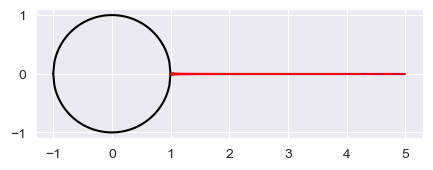

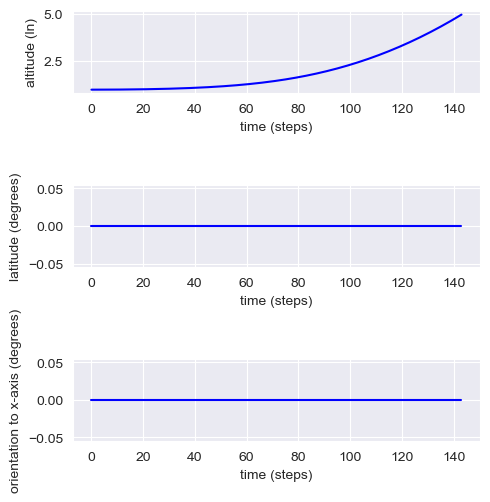

In [68]:
render_env.render()

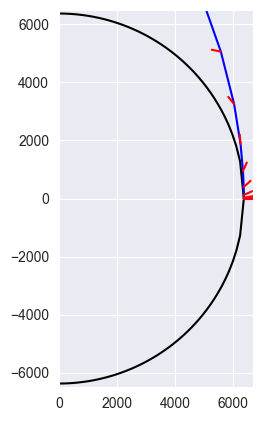

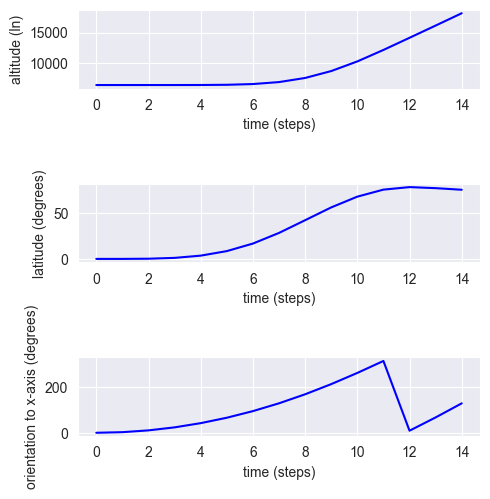

In [83]:
render_env.render(sample_traj_rate=1, xlim=[0, 6700], ylim=[-6500,6500])